# Lab 10 MNIST and Deep learning CNN

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [3]:
# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

In [4]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [5]:
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3 = tf.reshape(L3, [-1, 128 * 4 * 4])
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''

# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
hypothesis = tf.matmul(L4, W5) + b5
'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''

'\nTensor("add_1:0", shape=(?, 10), dtype=float32)\n'

In [6]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [7]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning stared. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _, = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning stared. It takes sometime.
Epoch: 0001 cost = 0.410797768
Epoch: 0002 cost = 0.098694173
Epoch: 0003 cost = 0.074164666
Epoch: 0004 cost = 0.059633818
Epoch: 0005 cost = 0.053323430
Epoch: 0006 cost = 0.045560739
Epoch: 0007 cost = 0.042134095
Epoch: 0008 cost = 0.039784185
Epoch: 0009 cost = 0.037420252
Epoch: 0010 cost = 0.032936082
Epoch: 0011 cost = 0.031048788
Epoch: 0012 cost = 0.030908969
Epoch: 0013 cost = 0.028281465
Epoch: 0014 cost = 0.026712128
Epoch: 0015 cost = 0.027753086
Learning Finished!


In [8]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
def evaluate(X_sample, y_sample, batch_size=512):
    """Run a minibatch accuracy op"""

    N = X_sample.shape[0]
    correct_sample = 0

    for i in range(0, N, batch_size):
        X_batch = X_sample[i: i + batch_size]
        y_batch = y_sample[i: i + batch_size]
        N_batch = X_batch.shape[0]

        feed = {
            X: X_batch,
            Y: y_batch,
            keep_prob: 1
        }

        correct_sample += sess.run(accuracy, feed_dict=feed) * N_batch

    return correct_sample / N

In [10]:
print("\nAccuracy Evaluates")
print("-------------------------------")
print('Train Accuracy:', evaluate(mnist.train.images, mnist.train.labels))
print('Test Accuracy:', evaluate(mnist.test.images, mnist.test.labels))


Accuracy Evaluates
-------------------------------
Train Accuracy: 0.9974
Test Accuracy: 0.993299999905


In [11]:
# Get one and predict
print("\nGet one and predict")
print("-------------------------------")
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), {X: mnist.test.images[r:r + 1], keep_prob: 1}))


Get one and predict
-------------------------------
Label:  [8]
Prediction:  [8]


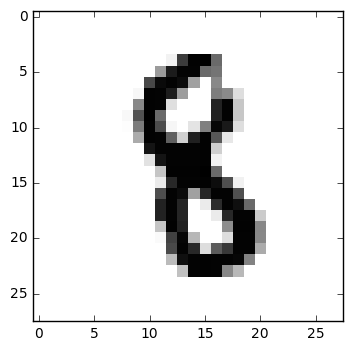

In [12]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()